In [135]:
import numpy as np
import awkward as ak
import uproot_methods

In [136]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [137]:
def pad_array(a, maxlen, value=0., dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
#         print(s)
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x

In [165]:
##and Professor suggests that we could use mass, classifacation for later application
def SetAKArr(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    prtclsdata = []
    prtclsexp = []
    _label1 = []
    _label2 = []
    _label3 = []
    _label4 = []
    _label5 = []
    
    dirty = 0
    first = 1
    #record the number of particles in one experiment
    for line in lines:
        if line.startswith('E'):
            if (prtclsdata and not dirty):
                prtclsexp.append(prtclsdata)
                exp_inf = line.split()
                _label1.append(float(exp_inf[1]))
                _label2.append(float(exp_inf[2]))
                _label3.append(float(exp_inf[3]))
                _label4.append(float(exp_inf[4]))
                _label5.append(float(exp_inf[5]))
            elif (not prtclsdata and first):
                exp_inf = line.split()
                _label1.append(float(exp_inf[1]))
                _label2.append(float(exp_inf[2]))
                _label3.append(float(exp_inf[3]))
                _label4.append(float(exp_inf[4]))
                _label5.append(float(exp_inf[5]))
            first = 0
            prtclsdata = []
            dirty = 0
        else:
            #we ignore the photon
            par = line.split()
            if (int(par[1]) == 22):
                dirty = 1
            if (not dirty):
                #no photon
#                 prtclsdata.append(float(par[2]))
#                 prtclsdata.append(float(par[3]))
#                 prtclsdata.append(float(par[4]))
#                 prtclsdata.append(float(par[5]))
#                 prtclsdata.append(float(par[6]))
#                 prtclsdata.append(int(par[0]))
                prtclsdata.append(int(par[1]))
    if (prtclsdata and not dirty):
        prtclsexp.append(prtclsdata)
    ##Create an Order Dic

    from collections import OrderedDict
    v = OrderedDict()
    prtclsexp_arr = np.array(prtclsexp)
    expinf = ak.JaggedArray.fromiter(prtclsexp_arr)
    v['allparticlesdata'] = expinf
    v['label'] = np.stack(_label5, axis = -1)
    return v

In [166]:
class Dataset(object):
    def __init__(self, filepath, feature_dict = {}, label = 'label', pad_len=18, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict) == 0:
#             feature_dict['points'] = ['part_energy', 'part_mass']
            feature_dict['features'] = ['allparticlesdata']
#             feature_dict['mask'] = ['part_energy']
        ##currently we use 'E' for experiments
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()
        
    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        a = SetAKArr(self.filepath)
        self._label = a[self.label]
        for k in self.feature_dict:
                cols = self.feature_dict[k]
                if not isinstance(cols, (list, tuple)):
                    cols = [cols]
                arrs = []
                for col in cols:
                    arrs.append(pad_array(a[col], self.pad_len))
#                     print(pad_array(a[col], self.pad_len))
#                     print(type(a[col]))
                    ##check the dimesion of a[col], and it should be array.
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)
        
    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

In [167]:
train_dataset = Dataset('train.txt', data_format='channel_last')
val_dataset = Dataset('val.txt', data_format='channel_last')
test_dataset = Dataset('test.txt', data_format = 'channel_last')

[2024-06-19 21:06:05,750] INFO: Start loading file train.txt
[2024-06-19 21:06:06,644] INFO: Finished loading file train.txt
[2024-06-19 21:06:06,645] INFO: Start loading file val.txt
[2024-06-19 21:06:06,765] INFO: Finished loading file val.txt
[2024-06-19 21:06:06,766] INFO: Start loading file test.txt
[2024-06-19 21:06:06,899] INFO: Finished loading file test.txt


In [168]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite
from simpleModel import get_simple_model

In [169]:
# model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
##this shows the number of classes for classification
try:
    num_classes = train_dataset.y.shape[1]
except:
    num_classes = 1
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
# # print(input_shapes)
# for k in train_dataset.X:
#     print(k)
#     print(train_dataset[k].shape)
# if 'lite' in model_type:
#     model = get_particle_net_lite(num_classes, input_shapes)
# else:
# model = get_particle_net(num_classes, input_shapes)
simple_model = get_simple_model(num_classes, input_shapes)

In [170]:
# Training parameters
batch_size = 384
epochs = 200

In [171]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [172]:
simple_model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(200)),
#               optimizer=keras.optimizers.Adam(learning_rate=),
              metrics=['accuracy'])
simple_model.summary()

[2024-06-19 21:06:11,560] INFO: Learning rate: 0.000100


Model: "Simple_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 18, 1)]           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               2432      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


In [173]:
from tensorflow.keras.callbacks import Callback
class LossLogger(Callback):
    def __init__(self, filename):
        super().__init__()
        self.filename = filename
#         self.lb = lb

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a') as f:
#             print("Epoch ", epoch + 1,": loss = ", logs["val_loss"], "\n", file = f)
#             if (epoch+1)%5==0 or epoch==0:
            print('V ', logs['val_loss'], file = f)
            print('L', logs['loss'], file = f)
#             print()
#             f.write()
# loss_logger = LossLogger('MSE_vac_loss.txt')
loss_logger = LossLogger('MSE_loss.txt')

In [174]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'simple_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath='loss.txt',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
# I change the monitor from val_acc to val_loss
# checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, loss_logger]
# callbacks = [lr_schedule]

In [175]:
train_dataset.shuffle()
simple_model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=200,
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks
            )

[2024-06-19 21:06:14,073] INFO: Learning rate: 0.001000


Epoch 1/200
136/144 [===========================>..] - ETA: 0s - loss: 4.5854 - accuracy: 0.0000e+00

[2024-06-19 21:06:14,549] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 2ms/step - loss: 4.3319 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.8906e-05


[2024-06-19 21:06:14,555] INFO: Learning rate: 0.001000


Epoch 2/200
101/144 [====================>.........] - ETA: 0s - loss: 2.1519e-06 - accuracy: 0.0000e+00

[2024-06-19 21:06:14,724] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.5098e-06 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.1855e-12


[2024-06-19 21:06:14,727] INFO: Learning rate: 0.001000


Epoch 3/200
101/144 [====================>.........] - ETA: 0s - loss: 1.5151e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:14,896] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.4762e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.0464e-12


[2024-06-19 21:06:14,898] INFO: Learning rate: 0.001000


Epoch 4/200
100/144 [===================>..........] - ETA: 0s - loss: 1.3188e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:15,066] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.1938e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:15,069] INFO: Learning rate: 0.001000


Epoch 5/200
143/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:15,246] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:15,249] INFO: Learning rate: 0.001000


Epoch 6/200
143/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:15,421] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:15,423] INFO: Learning rate: 0.001000


Epoch 7/200
 98/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:15,597] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:15,599] INFO: Learning rate: 0.001000


Epoch 8/200
140/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:15,781] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:15,784] INFO: Learning rate: 0.001000


Epoch 9/200
130/144 [==========================>...] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:15,976] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:15,978] INFO: Learning rate: 0.001000


Epoch 10/200
 95/144 [==================>...........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:16,148] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:16,150] INFO: Learning rate: 0.001000


Epoch 11/200
143/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:16,325] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:16,328] INFO: Learning rate: 0.000100


Epoch 12/200
136/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:16,509] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:16,512] INFO: Learning rate: 0.000100


Epoch 13/200
 97/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:16,677] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:16,680] INFO: Learning rate: 0.000100


Epoch 14/200
141/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:16,856] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:16,859] INFO: Learning rate: 0.000100


Epoch 15/200
142/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:17,034] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:17,036] INFO: Learning rate: 0.000100


Epoch 16/200
133/144 [==========================>...] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:17,222] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:17,224] INFO: Learning rate: 0.000100


Epoch 17/200
138/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:17,408] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:17,411] INFO: Learning rate: 0.000100


Epoch 18/200
142/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:17,592] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:17,595] INFO: Learning rate: 0.000100


Epoch 19/200
140/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:17,776] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:17,778] INFO: Learning rate: 0.000100


Epoch 20/200
138/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:17,959] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:17,961] INFO: Learning rate: 0.000100


Epoch 21/200
130/144 [==========================>...] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:18,155] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:18,158] INFO: Learning rate: 0.000100


Epoch 22/200
136/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:18,342] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:18,345] INFO: Learning rate: 0.000100


Epoch 23/200
138/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:18,531] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:18,534] INFO: Learning rate: 0.000100


Epoch 24/200
137/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:18,719] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:18,722] INFO: Learning rate: 0.000100


Epoch 25/200
134/144 [==========================>...] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:18,912] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:18,915] INFO: Learning rate: 0.000100


Epoch 26/200
137/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:19,101] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:19,104] INFO: Learning rate: 0.000100


Epoch 27/200
138/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:19,288] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:19,291] INFO: Learning rate: 0.000100


Epoch 28/200
132/144 [==========================>...] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:19,483] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:19,486] INFO: Learning rate: 0.000100


Epoch 29/200
139/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:19,669] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:19,673] INFO: Learning rate: 0.000100


Epoch 30/200
142/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:19,854] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:19,858] INFO: Learning rate: 0.000100


Epoch 31/200
101/144 [====================>.........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:20,020] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:20,022] INFO: Learning rate: 0.000100


Epoch 32/200
106/144 [=====================>........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:20,172] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:20,174] INFO: Learning rate: 0.000100


Epoch 33/200
107/144 [=====================>........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:20,332] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:20,334] INFO: Learning rate: 0.000100


Epoch 34/200
141/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:20,514] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:20,516] INFO: Learning rate: 0.000100


Epoch 35/200
 98/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:20,682] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:20,685] INFO: Learning rate: 0.000100


Epoch 36/200
142/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:20,862] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:20,864] INFO: Learning rate: 0.000100


Epoch 37/200
 96/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:21,040] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:21,043] INFO: Learning rate: 0.000100


Epoch 38/200
142/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:21,220] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:21,222] INFO: Learning rate: 0.000100


Epoch 39/200
142/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:21,397] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:21,399] INFO: Learning rate: 0.000100


Epoch 40/200
140/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:21,579] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:21,582] INFO: Learning rate: 0.000100


Epoch 41/200
 99/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:21,751] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:21,753] INFO: Learning rate: 0.000100


Epoch 42/200
130/144 [==========================>...] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:21,944] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:21,947] INFO: Learning rate: 0.000100


Epoch 43/200
143/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:22,126] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:22,128] INFO: Learning rate: 0.000100


Epoch 44/200
120/144 [========================>.....] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:22,276] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:22,279] INFO: Learning rate: 0.000100


Epoch 45/200
100/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:22,452] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:22,455] INFO: Learning rate: 0.000100


Epoch 46/200
142/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:22,634] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:22,636] INFO: Learning rate: 0.000100


Epoch 47/200
 97/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:22,807] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:22,809] INFO: Learning rate: 0.000100


Epoch 48/200
140/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:22,993] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:22,995] INFO: Learning rate: 0.000100


Epoch 49/200
106/144 [=====================>........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:23,155] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:23,157] INFO: Learning rate: 0.000100


Epoch 50/200
139/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:23,334] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:23,337] INFO: Learning rate: 0.000100


Epoch 51/200
 94/144 [==================>...........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:23,509] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:23,510] INFO: Learning rate: 0.000100


Epoch 52/200
100/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:23,680] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:23,682] INFO: Learning rate: 0.000100


Epoch 53/200
 95/144 [==================>...........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:23,858] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:23,861] INFO: Learning rate: 0.000100


Epoch 54/200
108/144 [=====================>........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:24,017] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:24,020] INFO: Learning rate: 0.000100


Epoch 55/200
 98/144 [===================>..........] - ETA: 0s - loss: 9.8374e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:24,180] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.6004e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:24,181] INFO: Learning rate: 0.000100


Epoch 56/200
101/144 [====================>.........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:24,347] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:24,349] INFO: Learning rate: 0.000100


Epoch 57/200
 99/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:24,518] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:24,521] INFO: Learning rate: 0.000100


Epoch 58/200
102/144 [====================>.........] - ETA: 0s - loss: 2.5323e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:24,683] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.6250e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:24,686] INFO: Learning rate: 0.000100


Epoch 59/200
103/144 [====================>.........] - ETA: 0s - loss: 1.6755e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:24,849] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.4576e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:24,851] INFO: Learning rate: 0.000100


Epoch 60/200
139/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:25,032] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:25,036] INFO: Learning rate: 0.000100


Epoch 61/200
 96/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:25,213] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:25,216] INFO: Learning rate: 0.000100


Epoch 62/200
 96/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:25,392] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:25,394] INFO: Learning rate: 0.000100


Epoch 63/200
142/144 [============================>.] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:25,574] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:25,576] INFO: Learning rate: 0.000100


Epoch 64/200
139/144 [===========================>..] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:25,753] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:25,756] INFO: Learning rate: 0.000100


Epoch 65/200
144/144 [==============================] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:25,928] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:25,930] INFO: Learning rate: 0.000100


Epoch 66/200
118/144 [=======================>......] - ETA: 0s - loss: 9.3840e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:26,077] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.3319e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:26,079] INFO: Learning rate: 0.000100


Epoch 67/200
108/144 [=====================>........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:26,229] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:26,232] INFO: Learning rate: 0.000100


Epoch 68/200
 96/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:26,405] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:26,407] INFO: Learning rate: 0.000100


Epoch 69/200
 98/144 [===================>..........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:26,578] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:26,580] INFO: Learning rate: 0.000100


Epoch 70/200
 94/144 [==================>...........] - ETA: 0s - loss: 0.1384 - accuracy: 0.0000e+00    

[2024-06-19 21:06:26,752] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0917 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.5458e-04


[2024-06-19 21:06:26,755] INFO: Learning rate: 0.000100


Epoch 71/200
133/144 [==========================>...] - ETA: 0s - loss: 7.1984e-06 - accuracy: 0.0000e+00

[2024-06-19 21:06:26,940] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.6505e-06 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2028e-10


[2024-06-19 21:06:26,944] INFO: Learning rate: 0.000100


Epoch 72/200
140/144 [============================>.] - ETA: 0s - loss: 3.1621e-11 - accuracy: 0.0000e+00

[2024-06-19 21:06:27,128] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 3.0795e-11 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.0464e-12


[2024-06-19 21:06:27,131] INFO: Learning rate: 0.000100


Epoch 73/200
130/144 [==========================>...] - ETA: 0s - loss: 6.8912e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:27,326] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.9489e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:27,328] INFO: Learning rate: 0.000100


Epoch 74/200
 99/144 [===================>..........] - ETA: 0s - loss: 6.6834e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:27,500] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.8225e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:27,503] INFO: Learning rate: 0.000100


Epoch 75/200
143/144 [============================>.] - ETA: 0s - loss: 6.8530e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:27,678] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.8225e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:27,682] INFO: Learning rate: 0.000100


Epoch 76/200
140/144 [============================>.] - ETA: 0s - loss: 8.5103e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:27,872] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 8.3388e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:27,875] INFO: Learning rate: 0.000100


Epoch 77/200
144/144 [==============================] - ETA: 0s - loss: 1.0360e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:28,059] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.0360e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:28,064] INFO: Learning rate: 0.000100


Epoch 78/200
130/144 [==========================>...] - ETA: 0s - loss: 1.4027e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:28,264] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.4404e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:28,268] INFO: Learning rate: 0.000100


Epoch 79/200
140/144 [============================>.] - ETA: 0s - loss: 7.4708e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:28,449] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 7.3279e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:28,453] INFO: Learning rate: 0.000100


Epoch 80/200
103/144 [====================>.........] - ETA: 0s - loss: 6.8654e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:28,613] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.8225e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:28,618] INFO: Learning rate: 0.000100


Epoch 81/200
143/144 [============================>.] - ETA: 0s - loss: 6.8530e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:28,791] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.8225e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:28,794] INFO: Learning rate: 0.000100


Epoch 82/200
113/144 [======================>.......] - ETA: 0s - loss: 6.7810e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:28,957] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.8225e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:28,960] INFO: Learning rate: 0.000100


Epoch 83/200
105/144 [====================>.........] - ETA: 0s - loss: 6.7779e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:29,106] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.8225e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:29,108] INFO: Learning rate: 0.000100


Epoch 84/200
102/144 [====================>.........] - ETA: 0s - loss: 6.9104e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:29,277] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.8225e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:29,279] INFO: Learning rate: 0.000100


Epoch 85/200
106/144 [=====================>........] - ETA: 0s - loss: 6.9070e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:29,437] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.9600e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1141e-11


[2024-06-19 21:06:29,439] INFO: Learning rate: 0.000100


Epoch 86/200
106/144 [=====================>........] - ETA: 0s - loss: 1.2154e-11 - accuracy: 0.0000e+00

[2024-06-19 21:06:29,594] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.1180e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:29,597] INFO: Learning rate: 0.000100


Epoch 87/200
105/144 [====================>.........] - ETA: 0s - loss: 1.1542e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:29,761] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.2901e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.1855e-12


[2024-06-19 21:06:29,763] INFO: Learning rate: 0.000100


Epoch 88/200
109/144 [=====================>........] - ETA: 0s - loss: 5.5195e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:29,914] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 5.5004e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.0464e-12


[2024-06-19 21:06:29,916] INFO: Learning rate: 0.000100


Epoch 89/200
112/144 [======================>.......] - ETA: 0s - loss: 1.4779e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:30,076] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.3517e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:30,078] INFO: Learning rate: 0.000100


Epoch 90/200
114/144 [======================>.......] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:30,219] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 978us/step - loss: 9.0949e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:30,221] INFO: Learning rate: 0.000100


Epoch 91/200
118/144 [=======================>......] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:30,364] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 989us/step - loss: 9.9919e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.0464e-12


[2024-06-19 21:06:30,366] INFO: Learning rate: 0.000100


Epoch 92/200
104/144 [====================>.........] - ETA: 0s - loss: 1.0997e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:30,527] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.0469e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.0949e-13


[2024-06-19 21:06:30,529] INFO: Learning rate: 0.000100


Epoch 93/200
104/144 [====================>.........] - ETA: 0s - loss: 9.0949e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:30,689] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 3.5958e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.0464e-12


[2024-06-19 21:06:30,691] INFO: Learning rate: 0.000100


Epoch 94/200
114/144 [======================>.......] - ETA: 0s - loss: 8.8157e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:30,844] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.2048e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1141e-11


[2024-06-19 21:06:30,848] INFO: Learning rate: 0.000100


Epoch 95/200
105/144 [====================>.........] - ETA: 0s - loss: 0.0055 - accuracy: 0.0000e+00  

[2024-06-19 21:06:31,004] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3670e-06


[2024-06-19 21:06:31,006] INFO: Learning rate: 0.000100


Epoch 96/200
111/144 [======================>.......] - ETA: 0s - loss: 1.0498e-07 - accuracy: 0.0000e+00

[2024-06-19 21:06:31,158] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 8.3265e-08 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.9468e-10


[2024-06-19 21:06:31,160] INFO: Learning rate: 0.000100


Epoch 97/200
113/144 [======================>.......] - ETA: 0s - loss: 8.3043e-09 - accuracy: 0.0000e+00

[2024-06-19 21:06:31,312] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 7.1335e-09 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.7402e-10


[2024-06-19 21:06:31,314] INFO: Learning rate: 0.000100


Epoch 98/200
108/144 [=====================>........] - ETA: 0s - loss: 4.3785e-09 - accuracy: 0.0000e+00

[2024-06-19 21:06:31,472] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 4.8500e-09 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 7.2853e-09


[2024-06-19 21:06:31,475] INFO: Learning rate: 0.000100


Epoch 99/200
101/144 [====================>.........] - ETA: 0s - loss: 1.0499e-08 - accuracy: 0.0000e+00

[2024-06-19 21:06:31,642] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.7325e-09 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1462e-09


[2024-06-19 21:06:31,645] INFO: Learning rate: 0.000100


Epoch 100/200
142/144 [============================>.] - ETA: 0s - loss: 1.8367e-07 - accuracy: 0.0000e+00

[2024-06-19 21:06:31,821] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 3.7821e-07 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.9337e-05


[2024-06-19 21:06:31,824] INFO: Learning rate: 0.000100


Epoch 101/200
105/144 [====================>.........] - ETA: 0s - loss: 0.0012 - accuracy: 0.0000e+00  

[2024-06-19 21:06:31,981] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 8.8901e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 4.4421e-08


[2024-06-19 21:06:31,983] INFO: Learning rate: 0.000100


Epoch 102/200
 99/144 [===================>..........] - ETA: 0s - loss: 1.5507e-07 - accuracy: 0.0000e+00

[2024-06-19 21:06:32,148] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 4.8733e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.2332e-04


[2024-06-19 21:06:32,150] INFO: Learning rate: 0.000100


Epoch 103/200
110/144 [=====================>........] - ETA: 0s - loss: 4.3275e-05 - accuracy: 0.0000e+00

[2024-06-19 21:06:32,310] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.6749e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0066


[2024-06-19 21:06:32,312] INFO: Learning rate: 0.000100


Epoch 104/200
114/144 [======================>.......] - ETA: 0s - loss: 4.6187e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:32,454] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 984us/step - loss: 3.6576e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.2316e-08


[2024-06-19 21:06:32,456] INFO: Learning rate: 0.000100


Epoch 105/200
116/144 [=======================>......] - ETA: 0s - loss: 0.0017 - accuracy: 0.0000e+00  

[2024-06-19 21:06:32,605] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.1542e-06


[2024-06-19 21:06:32,607] INFO: Learning rate: 0.000100


Epoch 106/200
121/144 [========================>.....] - ETA: 0s - loss: 1.2598e-07 - accuracy: 0.0000e+00

[2024-06-19 21:06:32,750] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 988us/step - loss: 1.0934e-07 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2344e-08


[2024-06-19 21:06:32,753] INFO: Learning rate: 0.000100


Epoch 107/200
113/144 [======================>.......] - ETA: 0s - loss: 2.0054e-06 - accuracy: 0.0000e+00

[2024-06-19 21:06:32,903] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 4.6401e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0013


[2024-06-19 21:06:32,905] INFO: Learning rate: 0.000100


Epoch 108/200
111/144 [======================>.......] - ETA: 0s - loss: 6.8480e-05 - accuracy: 0.0000e+00

[2024-06-19 21:06:33,054] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 5.3493e-05 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.0527e-05


[2024-06-19 21:06:33,056] INFO: Learning rate: 0.000100


Epoch 109/200
107/144 [=====================>........] - ETA: 0s - loss: 9.8546e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:33,218] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 7.3251e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.6699e-08


[2024-06-19 21:06:33,223] INFO: Learning rate: 0.000100


Epoch 110/200
112/144 [======================>.......] - ETA: 0s - loss: 5.7786e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:33,368] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 998us/step - loss: 4.6254e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1643e-05


[2024-06-19 21:06:33,370] INFO: Learning rate: 0.000100


Epoch 111/200
125/144 [=========================>....] - ETA: 0s - loss: 5.4264e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:33,505] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 935us/step - loss: 4.7583e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 6.1956e-08


[2024-06-19 21:06:33,507] INFO: Learning rate: 0.000100


Epoch 112/200
113/144 [======================>.......] - ETA: 0s - loss: 5.3466e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:33,652] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 4.6629e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 6.2981e-06


[2024-06-19 21:06:33,654] INFO: Learning rate: 0.000100


Epoch 113/200
114/144 [======================>.......] - ETA: 0s - loss: 5.3164e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:33,807] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 5.7947e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.8166e-04


[2024-06-19 21:06:33,809] INFO: Learning rate: 0.000100


Epoch 114/200
120/144 [========================>.....] - ETA: 0s - loss: 8.8845e-06 - accuracy: 0.0000e+00

[2024-06-19 21:06:33,954] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1000us/step - loss: 2.3262e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0072


[2024-06-19 21:06:33,955] INFO: Learning rate: 0.000100


Epoch 115/200
112/144 [======================>.......] - ETA: 0s - loss: 3.4004e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:34,107] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.6473e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.7656e-06


[2024-06-19 21:06:34,108] INFO: Learning rate: 0.000100


Epoch 116/200
120/144 [========================>.....] - ETA: 0s - loss: 7.7323e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:34,247] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 963us/step - loss: 6.4459e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 9.8560e-07


[2024-06-19 21:06:34,250] INFO: Learning rate: 0.000100


Epoch 117/200
125/144 [=========================>....] - ETA: 0s - loss: 6.7531e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:34,450] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 5.8805e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.4625e-07


[2024-06-19 21:06:34,455] INFO: Learning rate: 0.000100


Epoch 118/200
135/144 [===========================>..] - ETA: 0s - loss: 6.1178e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:34,643] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 5.9688e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.9587e-04


[2024-06-19 21:06:34,646] INFO: Learning rate: 0.000100


Epoch 119/200
131/144 [==========================>...] - ETA: 0s - loss: 2.4679e-05 - accuracy: 0.0000e+00

[2024-06-19 21:06:34,835] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.2673e-05 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 6.7585e-06


[2024-06-19 21:06:34,838] INFO: Learning rate: 0.000100


Epoch 120/200
138/144 [===========================>..] - ETA: 0s - loss: 6.0294e-04 - accuracy: 0.0000e+00

[2024-06-19 21:06:35,022] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 5.7799e-04 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.6843e-12


[2024-06-19 21:06:35,025] INFO: Learning rate: 0.000100


Epoch 121/200
135/144 [===========================>..] - ETA: 0s - loss: 6.3631e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:35,204] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.0792e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:35,207] INFO: Learning rate: 0.000100


Epoch 122/200
 97/144 [===================>..........] - ETA: 0s - loss: 8.1808e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:35,372] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 7.7649e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:35,375] INFO: Learning rate: 0.000100


Epoch 123/200
109/144 [=====================>........] - ETA: 0s - loss: 6.7795e-13 - accuracy: 0.0000e+00

[2024-06-19 21:06:35,527] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 6.8173e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2737e-13


[2024-06-19 21:06:35,529] INFO: Learning rate: 0.000100


Epoch 124/200
108/144 [=====================>........] - ETA: 0s - loss: 1.1684e-12 - accuracy: 0.0000e+00

[2024-06-19 21:06:35,682] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 9.0502e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:35,685] INFO: Learning rate: 0.000100


Epoch 125/200
111/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:35,847] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:35,850] INFO: Learning rate: 0.000100


Epoch 126/200
118/144 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:35,991] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 975us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:35,993] INFO: Learning rate: 0.000100


Epoch 127/200
110/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:36,143] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:36,145] INFO: Learning rate: 0.000100


Epoch 128/200
112/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:36,297] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:36,301] INFO: Learning rate: 0.000100


Epoch 129/200
 95/144 [==================>...........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:36,474] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:36,477] INFO: Learning rate: 0.000100


Epoch 130/200
137/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:36,665] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:36,667] INFO: Learning rate: 0.000100


Epoch 131/200
132/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:36,860] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:36,865] INFO: Learning rate: 0.000100


Epoch 132/200
 89/144 [=================>............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:37,036] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:37,039] INFO: Learning rate: 0.000100


Epoch 133/200
138/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:37,221] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:37,224] INFO: Learning rate: 0.000100


Epoch 134/200
134/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:37,419] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:37,422] INFO: Learning rate: 0.000100


Epoch 135/200
103/144 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:37,596] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:37,599] INFO: Learning rate: 0.000100


Epoch 136/200
124/144 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:37,800] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:37,803] INFO: Learning rate: 0.000100


Epoch 137/200
111/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:37,953] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:37,955] INFO: Learning rate: 0.000100


Epoch 138/200
108/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:38,109] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:38,111] INFO: Learning rate: 0.000100


Epoch 139/200
115/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:38,264] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:38,266] INFO: Learning rate: 0.000100


Epoch 140/200
112/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:38,410] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 998us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:38,413] INFO: Learning rate: 0.000100


Epoch 141/200
116/144 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:38,556] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 989us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:38,558] INFO: Learning rate: 0.000100


Epoch 142/200
108/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:38,715] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:38,717] INFO: Learning rate: 0.000100


Epoch 143/200
115/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:38,869] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:38,871] INFO: Learning rate: 0.000100


Epoch 144/200
118/144 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:39,013] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 972us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:39,015] INFO: Learning rate: 0.000100


Epoch 145/200
107/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:39,180] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:39,183] INFO: Learning rate: 0.000100


Epoch 146/200
 96/144 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:39,356] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:39,359] INFO: Learning rate: 0.000100


Epoch 147/200
140/144 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:39,542] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:39,545] INFO: Learning rate: 0.000100


Epoch 148/200
133/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:39,731] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:39,734] INFO: Learning rate: 0.000100


Epoch 149/200
 96/144 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:39,904] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:39,906] INFO: Learning rate: 0.000100


Epoch 150/200
109/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:40,060] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:40,062] INFO: Learning rate: 0.000100


Epoch 151/200
105/144 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:40,225] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:40,227] INFO: Learning rate: 0.000100


Epoch 152/200
114/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:40,373] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:40,375] INFO: Learning rate: 0.000100


Epoch 153/200
115/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:40,524] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:40,527] INFO: Learning rate: 0.000100


Epoch 154/200
112/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:40,680] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:40,682] INFO: Learning rate: 0.000100


Epoch 155/200
111/144 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:40,835] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:40,837] INFO: Learning rate: 0.000100


Epoch 156/200
107/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:40,989] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:40,992] INFO: Learning rate: 0.000100


Epoch 157/200
106/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:41,145] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:41,147] INFO: Learning rate: 0.000100


Epoch 158/200
118/144 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:41,297] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:41,300] INFO: Learning rate: 0.000100


Epoch 159/200
108/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:41,451] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:41,453] INFO: Learning rate: 0.000100


Epoch 160/200
107/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:41,612] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:41,615] INFO: Learning rate: 0.000100


Epoch 161/200
107/144 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:41,783] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:41,786] INFO: Learning rate: 0.000100


Epoch 162/200
141/144 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:41,964] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:41,967] INFO: Learning rate: 0.000100


Epoch 163/200
132/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:42,153] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:42,157] INFO: Learning rate: 0.000100


Epoch 164/200
140/144 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:42,335] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:42,339] INFO: Learning rate: 0.000100


Epoch 165/200
132/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:42,530] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:42,533] INFO: Learning rate: 0.000100


Epoch 166/200
131/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:42,723] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:42,725] INFO: Learning rate: 0.000100


Epoch 167/200
140/144 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:42,905] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:42,909] INFO: Learning rate: 0.000100


Epoch 168/200
131/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:43,105] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:43,107] INFO: Learning rate: 0.000100


Epoch 169/200
139/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:43,287] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:43,289] INFO: Learning rate: 0.000100


Epoch 170/200
117/144 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:43,434] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:43,436] INFO: Learning rate: 0.000100


Epoch 171/200
116/144 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:43,579] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 989us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:43,581] INFO: Learning rate: 0.000100


Epoch 172/200
139/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:43,765] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:43,768] INFO: Learning rate: 0.000100


Epoch 173/200
132/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:43,954] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:43,957] INFO: Learning rate: 0.000100


Epoch 174/200
140/144 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:44,140] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:44,143] INFO: Learning rate: 0.000100


Epoch 175/200
119/144 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:44,348] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:44,351] INFO: Learning rate: 0.000100


Epoch 176/200
 90/144 [=================>............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:44,520] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:44,522] INFO: Learning rate: 0.000100


Epoch 177/200
140/144 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:44,704] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:44,708] INFO: Learning rate: 0.000100


Epoch 178/200
127/144 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:44,902] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:44,906] INFO: Learning rate: 0.000100


Epoch 179/200
139/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:45,093] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:45,098] INFO: Learning rate: 0.000100


Epoch 180/200
120/144 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:45,305] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:45,309] INFO: Learning rate: 0.000100


Epoch 181/200
128/144 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:45,508] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:45,511] INFO: Learning rate: 0.000100


Epoch 182/200
134/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:45,704] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:45,707] INFO: Learning rate: 0.000100


Epoch 183/200
127/144 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:45,902] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:45,905] INFO: Learning rate: 0.000100


Epoch 184/200
136/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:46,097] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:46,100] INFO: Learning rate: 0.000100


Epoch 185/200
130/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:46,294] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:46,299] INFO: Learning rate: 0.000100


Epoch 186/200
130/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:46,495] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:46,498] INFO: Learning rate: 0.000100


Epoch 187/200
131/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:46,690] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:46,694] INFO: Learning rate: 0.000100


Epoch 188/200
128/144 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:46,898] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:46,901] INFO: Learning rate: 0.000100


Epoch 189/200
132/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:47,094] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:47,097] INFO: Learning rate: 0.000100


Epoch 190/200
135/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:47,291] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:47,295] INFO: Learning rate: 0.000100


Epoch 191/200
133/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:47,485] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:47,488] INFO: Learning rate: 0.000100


Epoch 192/200
134/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:47,676] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:47,678] INFO: Learning rate: 0.000100


Epoch 193/200
138/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:47,862] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:47,865] INFO: Learning rate: 0.000100


Epoch 194/200
134/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:48,054] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:48,056] INFO: Learning rate: 0.000100


Epoch 195/200
132/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:48,248] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:48,250] INFO: Learning rate: 0.000100


Epoch 196/200
139/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:48,431] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:48,434] INFO: Learning rate: 0.000100


Epoch 197/200
130/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:48,630] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:48,633] INFO: Learning rate: 0.000100


Epoch 198/200
136/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:48,821] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:48,825] INFO: Learning rate: 0.000100


Epoch 199/200
133/144 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:49,014] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


[2024-06-19 21:06:49,017] INFO: Learning rate: 0.000100


Epoch 200/200
137/144 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

[2024-06-19 21:06:49,202] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


In [180]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'
def PlotPrediction(filepath, fig, tag):
    #open files
    with open(filepath, 'r') as file:
        lines = file.readlines()
    output = open('200pre_MEPoint.txt', 'w')
        
    ##this piece of code would load the 
    ##real particle infor in order to be compared with the predictions
    true_vals = []
    true_val = []
    masses = []
    for line in lines:
        if line.startswith('E'):
            if not true_val:
                true_vals.append(true_val)
            true_val = []
            info = line.split()
            px = float(info[1])
            py = float(info[2])
            pz = float(info[3])
            engy = float(info[4])
            mass = float(info[5])
            true_val.append(px)
            true_val.append(py)
            true_val.append(pz)
            true_val.append(engy)
            true_val.append(mass)
            if tag == 'Px':
                masses.append(px)
            elif tag == 'Py':
                masses.append(py)
            elif tag == 'Pz':
                masses.append(pz)
            elif tag == 'Engy':
                masses.append(engy)
            else:
                masses.append(mass)
    
    predictions = simple_model.predict(test_dataset.X)
    print(predictions)
    x = []
    for i in range(0, predictions.size):
        x.append(i)
        i += 1
    quans = []
##this is for multiple output variables
#     if tag == 'Px':
#         idx = 0
#     elif tag == 'Py':
#         idx = 1
#     elif tag == 'Pz':
#         idx = 2
#     elif tag == 'Engy':
#         idx = 3
#     else:
#         idx = 4
    #idx = mass
    idx = 0
    for prediction in predictions:
        #this would grab the desired information
        quan = prediction[idx]
        quans.append(quan)
        ##his would output the prediction into text
        for energy_momentum in prediction:
            print(energy_momentum, end='', file=output)
        print('', file=output)
        
#     fig, ax = plt.subplots()
#     ax.set_title("Mass Prediction")
#     plt.xlabel("Number of Prediction")
#     plt.ylabel("Mass")
#     ax.scatter(x, masses, linewidth=2.0, color = 'blue')

    plt.hist(quans, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    plt.hist(masses, 40, label='prediction', density=False, histtype = 'step', cumulative=False, color = 'b', alpha = 0.75)
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)

#     plt.legend(
#     loc='best',
#     labels = ['log_cosh', 'mse'])
#     plt.show()
    plt.savefig(fig)

[[5.279333 ]
 [5.279333 ]
 [5.279333 ]
 ...
 [5.2793283]
 [5.2793283]
 [5.2793283]]


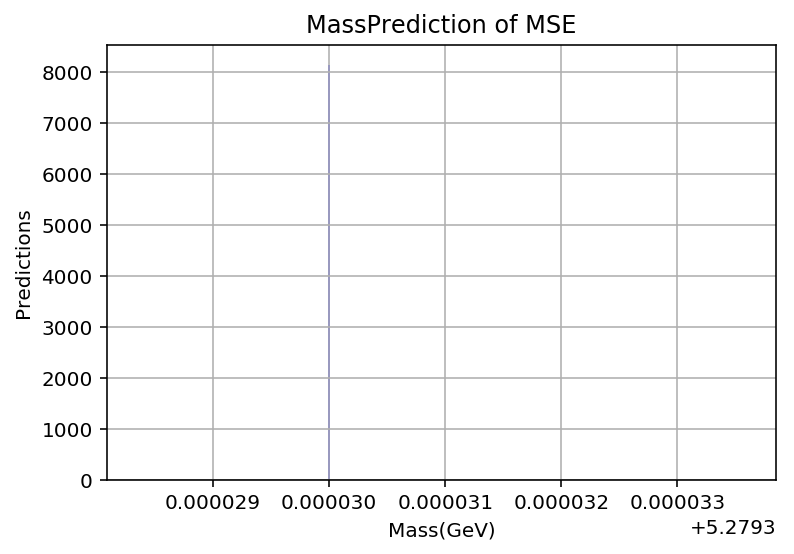

In [181]:
PlotPrediction('test.txt','predictions/Mass_200epPre.png','Mass')

In [182]:
def PlotWithoutModel(filepath, fig, tag):
    TrueMass = 5.27933
    with open(filepath, 'r') as file:
        lines = file.readlines()
    masses = []
    for line in lines:
        masses.append(float(line))
    plt.hist(masses, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    # Mark True mass
    plt.axvline(TrueMass, color='red', linestyle='--', label='Marked Point')
    
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)
    plt.savefig(fig)

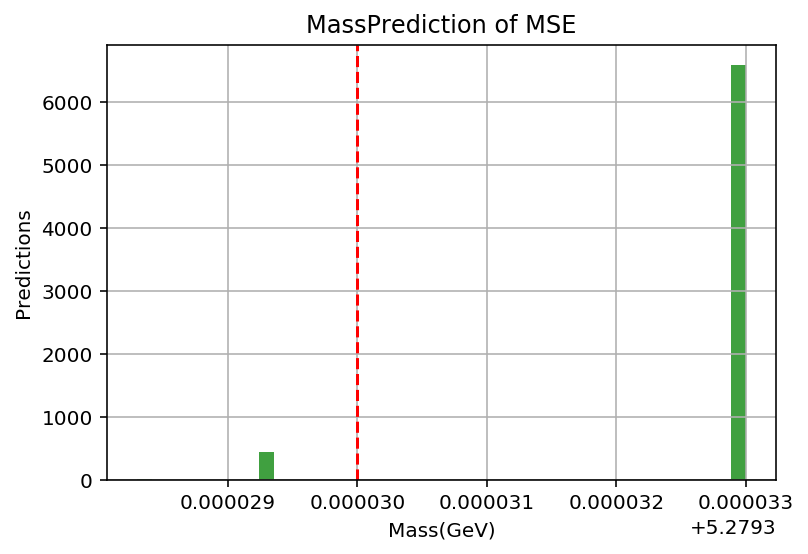

In [183]:
PlotWithoutModel('200pre_MEPoint.txt', '200masspre.png', 'Mass')